<a href="https://colab.research.google.com/github/worldofaryavart/colab_notebooks/blob/colabnotebook/animal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive
import os

In [2]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
torch.manual_seed(42)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
data_dir = '/content/drive/MyDrive/dataset/'
print("Available classes:", os.listdir(data_dir))

Available classes: ['Bird', 'Giraffe', 'Dog', 'Cat', 'Cow', 'Dolphin', 'Elephant', 'Horse', 'Deer', 'Bear', 'Zebra', 'Kangaroo', 'Panda', 'Lion', 'Tiger']


In [7]:
full_dataset = ImageFolder(data_dir, transform=train_transform)


In [8]:
total_size = len(full_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size   # 20% for validation

In [9]:
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


In [10]:
val_dataset.dataset.transform = val_transform


In [11]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [12]:
print(f"\nTotal images: {total_size}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Classes: {full_dataset.classes}")


Total images: 1948
Training images: 1558
Validation images: 390
Number of classes: 15
Classes: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']


In [13]:
model = models.resnet50(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]


In [14]:
num_classes = len(full_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

In [16]:

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy


In [17]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy


In [18]:
num_epochs = 20
best_val_acc = 0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [19]:
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')

    # Train
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validate
    val_loss, val_acc = validate_model(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_val_acc,
        }, '/content/drive/MyDrive/best_animal_classifier.pth')



Epoch 1/20


Validation: 100%|██████████| 13/13 [01:20<00:00,  6.22s/it]


Train Loss: 1.5752 Train Acc: 54.62%
Val Loss: 7.0132 Val Acc: 36.92%

Epoch 2/20


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


Train Loss: 0.8546 Train Acc: 74.39%
Val Loss: 1.8659 Val Acc: 54.87%

Epoch 3/20


Validation: 100%|██████████| 13/13 [00:02<00:00,  6.07it/s]


Train Loss: 0.6171 Train Acc: 81.45%
Val Loss: 0.7887 Val Acc: 74.36%

Epoch 4/20


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.96it/s]


Train Loss: 0.4096 Train Acc: 87.68%
Val Loss: 5.8648 Val Acc: 57.95%

Epoch 5/20


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Train Loss: 0.3106 Train Acc: 91.66%
Val Loss: 0.7388 Val Acc: 82.05%

Epoch 6/20


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.16it/s]


Train Loss: 0.2096 Train Acc: 93.32%
Val Loss: 0.8590 Val Acc: 77.44%

Epoch 7/20


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.02it/s]


Train Loss: 0.2205 Train Acc: 94.09%
Val Loss: 0.7990 Val Acc: 77.44%

Epoch 8/20


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.05it/s]


Train Loss: 0.2231 Train Acc: 93.77%
Val Loss: 1.8218 Val Acc: 75.13%

Epoch 9/20


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.70it/s]


Train Loss: 0.2738 Train Acc: 91.01%
Val Loss: 4.7310 Val Acc: 58.21%

Epoch 10/20


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.87it/s]


Train Loss: 0.1242 Train Acc: 96.47%
Val Loss: 0.2667 Val Acc: 92.05%

Epoch 11/20


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Train Loss: 0.0311 Train Acc: 99.49%
Val Loss: 0.2325 Val Acc: 93.33%

Epoch 12/20


Validation: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Train Loss: 0.0165 Train Acc: 99.81%
Val Loss: 0.2285 Val Acc: 93.59%

Epoch 13/20


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.25it/s]


Train Loss: 0.0123 Train Acc: 99.94%
Val Loss: 0.1975 Val Acc: 93.59%

Epoch 14/20


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.22it/s]


Train Loss: 0.0122 Train Acc: 99.87%
Val Loss: 0.1951 Val Acc: 93.08%

Epoch 15/20


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.97it/s]


Train Loss: 0.0091 Train Acc: 100.00%
Val Loss: 0.1935 Val Acc: 92.82%

Epoch 16/20


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.22it/s]


Train Loss: 0.0071 Train Acc: 99.94%
Val Loss: 0.1872 Val Acc: 93.59%

Epoch 17/20


Validation: 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]


Train Loss: 0.0069 Train Acc: 99.94%
Val Loss: 0.1862 Val Acc: 93.85%

Epoch 18/20


Validation: 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]


Train Loss: 0.0053 Train Acc: 100.00%
Val Loss: 0.1841 Val Acc: 93.33%

Epoch 19/20


Validation: 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]


Train Loss: 0.0066 Train Acc: 99.87%
Val Loss: 0.1665 Val Acc: 94.36%

Epoch 20/20


Validation: 100%|██████████| 13/13 [00:02<00:00,  5.38it/s]

Train Loss: 0.0132 Train Acc: 99.81%
Val Loss: 0.1734 Val Acc: 93.33%


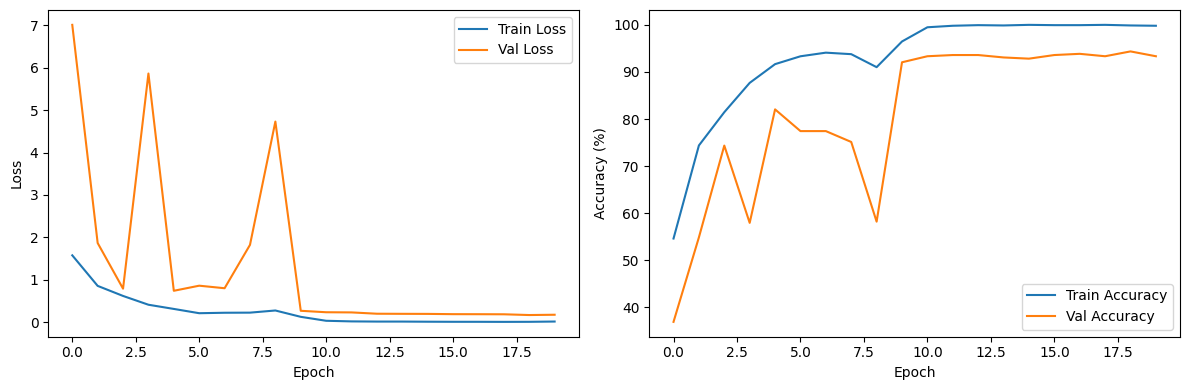

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
from PIL import Image

def predict_image(image_path, model, transform):
    model.eval()
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        _, predicted = output.max(1)

    # Get top 3 predictions
    top3_prob, top3_catid = torch.topk(probabilities, 3)
    predictions = []
    for i in range(3):
        predictions.append((
            full_dataset.classes[top3_catid[i].item()],
            top3_prob[i].item() * 100
        ))

    return predictions

In [24]:
test_image_path = '/content/drive/MyDrive/dataset/Bear/Bear_10.jpg'
predictions = predict_image(test_image_path, model, val_transform)
for class_name, probability in predictions:
    print(f'{class_name}: {probability:.2f}%')

Bear: 100.00%
Panda: 0.00%
Elephant: 0.00%
